In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import io
import itertools
import warnings
import statsmodels.stats.proportion

import polars as pl
pl.Config.set_tbl_rows(-1)
pl.Config.set_fmt_str_lengths(50)


from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *

# Add relevant fields to the dataframe of all reads

## Create reads dataframe

In [4]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ) 
    for focal_sample_id in tqdm.tqdm(normal_sample_ids)
    for chrom in aut_chrom_names
])

100%|██████████| 2/2 [00:02<00:00,  1.27s/it]

CPU times: user 43.4 ms, sys: 43.9 ms, total: 87.3 ms
Wall time: 2.55 s


## Subset of reads with at least 3 SNPs 

In [5]:
%%time
dense_reads_with_detection_df = (reads_df
    .select(
        'read_name',
        'read_length',
        'chrom',
        'sample_id',
        'grch37_chromosome_size_in_bp',
        'high_quality_snp_positions',
        "high_quality_snp_positions_alleles",
        'CO_active_interval_start',
        'CO_active_interval_end',
        'CO_active_interval_length_bp',
        'NCO_active_interval_start',
        'NCO_active_interval_end',
        'NCO_active_interval_length_bp',
        'grch37_reference_start',
        'grch38_reference_start',
        'grch37_reference_end',
        'grch38_reference_end',
        'T2T_reference_start',
        'grch37_reference_start_cM',
        'grch37_reference_end_cM',
        'CO_active_interval_start_cM',
        'CO_active_interval_end_cM',
        'CO_active_interval_crossover_prob',
        'NCO_active_interval_start_cM',
        'NCO_active_interval_end_cM',
        'NCO_active_interval_crossover_prob',
        "NCO_prob_detection_in_CO_active_interval",
        "full_read_crossover_prob",
        'AA_motif_center_pos',
        'AA_heat',
        'AA_motif_strand',
        'CL4_motif_center_pos',
        'CL4_heat',
        'CL4_motif_strand',
        'is_high_quality_read', 
        "high_quality_classification_class",
        "snp_positions_on_read", 
        "idx_transitions",
        "high_quality_classification_in_detectable_class",
        "H3K4me3_signal_mean",
        "CTCF_signal_mean",                
    )                  
    .filter(pl.col("high_quality_snp_positions").list.len() >= 3)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    .collect()
)

CPU times: user 44.8 s, sys: 21.7 s, total: 1min 6s
Wall time: 29.4 s


## Add annotation for CO and NCO reads only

In [6]:
CO_NCO_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_classification_class").is_in(["CO", "GC"]))
    .with_columns(
        grch37_recombining_interval_start_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch37_recombining_interval_end_pos = pl.col("grch37_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
        grch38_recombining_interval_start_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0)),
        grch38_recombining_interval_end_pos = pl.col("grch38_reference_start") + pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(-1) + 1),
    )
    .with_columns(
        grch37_recombining_interval_length = pl.col("grch37_recombining_interval_end_pos") - pl.col("grch37_recombining_interval_start_pos"),                
        grch38_recombining_interval_length = pl.col("grch38_recombining_interval_end_pos") - pl.col("grch38_recombining_interval_start_pos"),                
    )
)

dfs = []
for [chrom], df in CO_NCO_df.partition_by(by=["chrom"], as_dict=True).items():
    rate_map = annotate.rate_maps[chrom]
    dfs.append(
        df.with_columns(
            grch37_recombining_interval_start_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_start_pos"]) * 1e2,
            grch37_recombining_interval_end_poses_cm = rate_map.get_cumulative_mass(df["grch37_recombining_interval_end_pos"]) * 1e2,
        ).with_columns(
            grch37_recombining_interval_cM = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")),
            grch37_cM_per_bp_across_recombining_interval = (pl.col("grch37_recombining_interval_end_poses_cm") - pl.col("grch37_recombining_interval_start_poses_cm")) / pl.col("grch37_recombining_interval_length"),
        )
    )
    
CO_NCO_df = pl.concat(dfs)

# Numbers

# Differences in genetic lengths

## Different chromosomes and samples?

In [8]:
def test_condition(condition):
    df = (dense_reads_with_detection_df
        .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
        .filter(condition)
        .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
        .select(
            "CO_active_interval_crossover_prob",
            "high_quality_classification_in_detectable_class",
        )
    )

    CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
    NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
    
    return len(CO_lens), len(NCO_lens), scipy.stats.ks_2samp(CO_lens, NCO_lens).pvalue, inference.permutation_testing([[CO_lens, NCO_lens]], 1000)

In [10]:
rows = []
for sample_id in tqdm.tqdm(sorted(normal_sample_ids)):
    rows.append([sample_id] + list(test_condition(pl.col("sample_id") == sample_id)))
    
with pl.Config(tbl_rows=100) as cfg:
    display(pl.DataFrame(rows, schema=["sample_id", "n_events_CO", "n_events_NCO", "KS_pvalue", "AD_perm_pvalue"]))    


100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


sample_id,n_events_CO,n_events_NCO,KS_pvalue,AD_perm_pvalue
str,i64,i64,f64,f64
"""PD47269d""",9,15,0.265275,0.153
"""PD48473b""",4,15,0.024252,0.007


### See visually

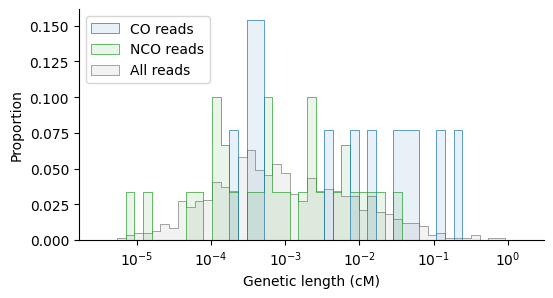

In [11]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
all_lens = dense_reads_with_detection_df.sample(fraction=1e-4)["CO_active_interval_crossover_prob"] * 1e2

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
    ], 
    bins=np.linspace(-5.5, 0.2, 50), 
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
    lw=0.5,
)

ax.set_xlabel("Genetic length (cM)");
ax.set_xticks(
    np.arange(-5, 1),
    [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
);
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)


# Compare DSB signal strengths between CO and NCO

## Overall

In [15]:
heats_CO = (CO_NCO_df
    .filter(pl.col("grch38_reference_start").is_not_null())            
    .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
)["AA_heat"].fill_null(0).to_numpy()

heats_NCO = (CO_NCO_df
    .filter(pl.col("grch38_reference_start").is_not_null())             
    .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
)["AA_heat"].fill_null(0).to_numpy()

0.7971603816834222 0.241 0.103 0.41162067070463687


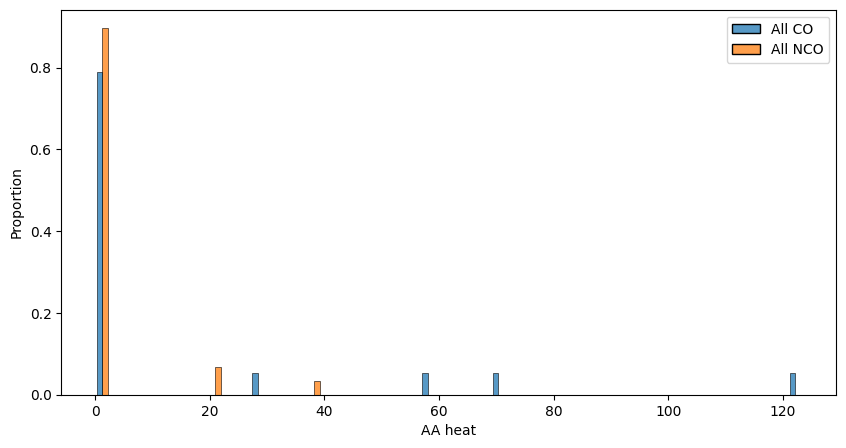

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(
    [
        pd.Series(heats_CO, name="All CO"),
        pd.Series(heats_NCO, name="All NCO"),
    ], 
    bins=50, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("AA heat");
#plt.title(f"AD perm pval = {pval}");

print(
    scipy.stats.ks_2samp(heats_CO, heats_NCO).pvalue,
    inference.permutation_testing([[heats_CO, heats_NCO]], 1000),
    inference.permutation_testing([[heats_CO[heats_CO>0], heats_NCO[heats_NCO>0]]], 1000),
    scipy.stats.fisher_exact(
        [[(heats_CO==0).sum(), (heats_CO!=0).sum()],
         [(heats_NCO==0).sum(), (heats_NCO!=0).sum()]],
    ).pvalue,
)

## Per sample

In [17]:
rows = []
for sample_id in tqdm.tqdm(normal_sample_ids):
    heats_CO = (CO_NCO_df
        .filter(pl.col("grch38_reference_start").is_not_null())                
        #.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
        .filter(pl.col("high_quality_classification_class") == "CO")
        .filter((pl.col("sample_id") == sample_id))
    )["AA_heat"].fill_null(0).to_numpy()

    heats_NCO = (CO_NCO_df
        .filter(pl.col("grch38_reference_start").is_not_null())                 
        #.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
        .filter(pl.col("high_quality_classification_class") == "GC")
        .filter((pl.col("sample_id") == sample_id))
    )["AA_heat"].fill_null(0).to_numpy()
    
    rows.append(
        [
            sample_id, 
            len(heats_CO), 
            len(heats_NCO),
            (heats_CO == 0).sum(),
            (heats_NCO == 0).sum(),
            scipy.stats.ks_2samp(heats_CO, heats_NCO).pvalue,
            inference.permutation_testing([[heats_CO, heats_NCO]], 1000),
            inference.permutation_testing([[heats_CO[heats_CO>0], heats_NCO[heats_NCO>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_CO==0).sum(), (heats_CO!=0).sum()],
                 [(heats_NCO==0).sum(), (heats_NCO!=0).sum()]],
            ).pvalue,
        ]
    )
    
AA_heats_co_vs_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_CO", "n_NCO", "n_CO_zeros", "n_NCO_zeros",
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


In [18]:
AA_heats_co_vs_nco_df.sort("heats_AD_perm_pvalue")

sample_id,n_CO,n_NCO,n_CO_zeros,n_NCO_zeros,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,i64,i64,i64,i64,f64,f64,f64,f64
"""PD48473b""",7,19,4,15,0.222022,0.117,0.055,0.340055
"""PD47269d""",21,17,19,15,0.999784,0.726,1.0,1.0


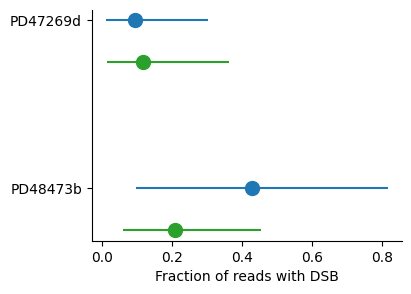

In [27]:
fig, ax = plt.subplots(figsize=(4,3))

rows = AA_heats_co_vs_nco_df.rows(named=True)
Drows = {}
for row in rows:
    Drows[row["sample_id"]] = row

# COs
mns_co = [(1 - Drows[s]["n_CO_zeros"]/Drows[s]["n_CO"]) \
       for s in normal_sample_ids]
cis_co = [statsmodels.stats.proportion.proportion_confint(
    Drows[s]["n_CO"] - Drows[s]["n_CO_zeros"],
    Drows[s]["n_CO"],
    method="beta",
) for s in normal_sample_ids]
    
ax.errorbar(
    y = 2*np.arange(len(normal_sample_ids)),
    x = mns_co,
    xerr = [
        [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis_co, mns_co)],
        [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis_co, mns_co)],
    ],
    fmt=".",
    ms=20,
    color=CO_color,
    
);

# COs
mns_nco = [(1 - Drows[s]["n_NCO_zeros"]/Drows[s]["n_NCO"]) \
       for s in normal_sample_ids]
cis_nco = [statsmodels.stats.proportion.proportion_confint(
    Drows[s]["n_NCO"] - Drows[s]["n_NCO_zeros"],
    Drows[s]["n_NCO"],
    method="beta",
) for s in normal_sample_ids]
    
ax.errorbar(
    y = 2*np.arange(len(normal_sample_ids))+0.5,
    x = mns_nco,
    xerr = [
        [mn-low_ci for ((low_ci, high_ci), mn) in zip(cis_nco, mns_nco)],
        [high_ci-mn for ((low_ci, high_ci), mn) in zip(cis_nco, mns_nco)],
    ],
    fmt=".",
    ms=20,
    color=NCO_color,
    
);

ax.set_yticks(
    ticks = 2*np.arange(len(normal_sample_ids)), 
    labels=normal_sample_ids, 
);
ax.invert_yaxis()
ax.set_xlabel("Fraction of reads with DSB");

ax.spines[['top', 'right']].set_visible(False)

In [23]:
AA_heats_co_vs_nco_df

sample_id,n_CO,n_NCO,n_CO_zeros,n_NCO_zeros,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,i64,i64,i64,i64,f64,f64,f64,f64
"""PD50508b""",152,43,28,19,0.018632,0.004,0.229,0.001016
"""PD50508f""",117,29,32,10,0.486841,0.527,0.552,0.494368
"""PD46180c""",251,61,56,25,0.023962,0.016,0.465,0.005177
"""PD50519d""",163,75,44,40,0.001084,0.0,0.64,0.000129
"""PD50477f""",189,63,50,30,0.006614,0.004,0.864,0.002792
"""PD50489e""",163,39,58,20,0.37458,0.116,0.643,0.098519
"""1894""",488,218,150,152,1.4432e-22,0.0,0.062,4.4009e-22
"""3898""",420,195,123,99,0.000005,0.0,0.539,3.7807e-7
"""7899""",469,201,132,104,5.4071e-9,0.0,0.486,7.8135e-9


# Telomere distances

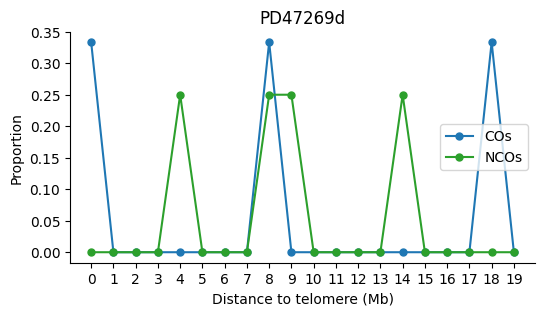

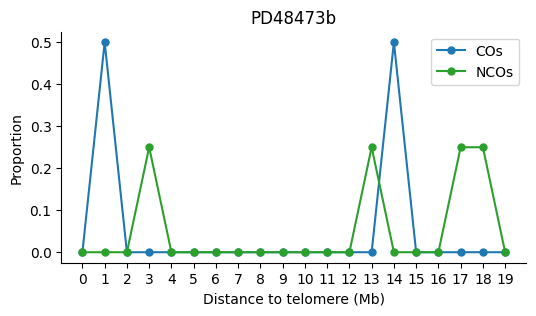

In [28]:
telomere_cutoff = 20e6 
telomere_step = telomere_cutoff/20

min_snps = 5

for sample_id in normal_sample_ids:
    # Look at p and q arm separately
    # p arm, exclude acrocentric chroms
    acrocentric_chroms = ["chr13", "chr14", "chr15", "chr21", "chr22"]
    p_arm_distances = (CO_NCO_df
        .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
        .filter(pl.col("sample_id") == sample_id)
        .select(
            "read_name",
            dist_from_p_telomere = pl.when(
                ~pl.col("chrom").is_in(acrocentric_chroms)  
            ).then(
               pl.col("T2T_reference_start") + pl.col("read_length")//2
            )
        )
    )

    # q arm, all chroms
    q_arm_distances = (CO_NCO_df
        .filter(pl.col("sample_id") == sample_id)
        .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
        .join(
            pl.DataFrame(list(liftover.T2T_chromosome_sizes_in_bp.items()), schema=["chrom", "T2T_chrom_length"]),
            on="chrom",
        )
        .select(
            "read_name",
            dist_from_q_telomere = pl.col("T2T_chrom_length") - (pl.col("T2T_reference_start") + pl.col("read_length")//2),
        )
    )

    close_to_telomeres_df = (CO_NCO_df
        .filter(pl.col("sample_id") == sample_id)
        .filter(pl.col("high_quality_snp_positions").list.len() >= min_snps)
        .join(p_arm_distances, on="read_name")
        .join(q_arm_distances, on="read_name")
        .with_columns(
            distance_to_telomere = pl.min_horizontal("dist_from_p_telomere", "dist_from_q_telomere")
        )
        .filter(pl.col("distance_to_telomere") < telomere_cutoff)
    )

    high_qual_CO_telomere_exp_probs = (close_to_telomeres_df
        .group_by(
            pl.col("distance_to_telomere") // telomere_step
        )
        .agg(
            pl.col("CO_active_interval_crossover_prob").mean().alias("prob")
        )
        .sort("distance_to_telomere")
    )["prob"]

    high_qual_CO_telomere_exp_freqs = high_qual_CO_telomere_exp_probs / high_qual_CO_telomere_exp_probs.sum()


    high_qual_NCO_telomere_exp_probs = (close_to_telomeres_df
        .group_by(
            pl.col("distance_to_telomere") // telomere_step
        )
        .agg(
            (pl.col("NCO_active_interval_crossover_prob") * pl.col("NCO_prob_detection_in_CO_active_interval")).mean().alias("prob")
        )
        .sort("distance_to_telomere")
    )["prob"]

    high_qual_NCO_telomere_exp_freqs = high_qual_NCO_telomere_exp_probs / high_qual_NCO_telomere_exp_probs.sum()

    bins = np.arange(0, telomere_cutoff + telomere_step, telomere_step)

    high_qual_CO_telomere_counts = np.histogram(
        close_to_telomeres_df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["distance_to_telomere"],
        bins=bins,
    )[0]

    high_qual_CO_telomere_freqs = high_qual_CO_telomere_counts / high_qual_CO_telomere_counts.sum()


    high_qual_NCO_telomere_counts = np.histogram(
        close_to_telomeres_df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["distance_to_telomere"],
        bins=bins,
    )[0]

    high_qual_NCO_telomere_freqs = high_qual_NCO_telomere_counts / high_qual_NCO_telomere_counts.sum()

    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(bins[:-1], high_qual_CO_telomere_freqs, '.-', label="COs", ms=10, color=CO_color)
    #ax.plot(bins[:-1], high_qual_CO_telomere_exp_freqs, '.--', label="COs (expected)", ms=5, color="C0", alpha=0.5)

    ax.plot(bins[:-1], high_qual_NCO_telomere_freqs, '.-', label="NCOs", ms=10, color=NCO_color)
    #ax.plot(bins[:-1], high_qual_NCO_telomere_exp_freqs, '.--', label="NCOs (expected)", ms=5, color="C1", alpha=0.5)
    ax.legend();

    ax.set_xticks(
        bins[:-1],
        labels = [f"{int(x/1e6)}" for x in bins[:-1]],
    );

    ax.set_xlabel("Distance to telomere (Mb)");
    ax.set_ylabel("Proportion");
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_title(sample_id)

# ENCODE H3K4me3

In [29]:
rows = []
for sample_id in tqdm.tqdm(normal_sample_ids):
    heats_CO = (CO_NCO_df
        .filter(pl.col("grch37_reference_start").is_not_null())                
        .filter(pl.col("high_quality_classification_in_detectable_class") == "CO")
        .filter((pl.col("sample_id") == sample_id))
    )["H3K4me3_signal_mean"].fill_null(0).to_numpy()

    heats_NCO = (CO_NCO_df
        .filter(pl.col("grch37_reference_start").is_not_null())                 
        .filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")
        .filter((pl.col("sample_id") == sample_id))
    )["H3K4me3_signal_mean"].fill_null(0).to_numpy()
    
    rows.append(
        [
            sample_id, 
            len(heats_CO), 
            len(heats_NCO),
            (heats_CO == 0).sum(),
            (heats_NCO == 0).sum(),
            scipy.stats.ks_2samp(heats_CO, heats_NCO).pvalue,
            inference.permutation_testing([[heats_CO, heats_NCO]], 1000),
            inference.permutation_testing([[heats_CO[heats_CO>0], heats_NCO[heats_NCO>0]]], 1000),
            scipy.stats.fisher_exact(
                [[(heats_CO==0).sum(), (heats_CO!=0).sum()],
                 [(heats_NCO==0).sum(), (heats_NCO!=0).sum()]],
            ).pvalue,
        ]
    )
    
H3K4me3_heats_co_vs_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id", "n_CO", "n_NCO", "n_CO_zeros", "n_NCO_zeros",
            "heats_ks_pvalue", 
            "heats_AD_perm_pvalue", 
            "heats_AD_perm_no_zeros_pvalue",
            "heats_fisher_pvalue",
           ],
)    

H3K4me3_heats_co_vs_nco_df.sort("heats_AD_perm_pvalue")

100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


sample_id,n_CO,n_NCO,n_CO_zeros,n_NCO_zeros,heats_ks_pvalue,heats_AD_perm_pvalue,heats_AD_perm_no_zeros_pvalue,heats_fisher_pvalue
str,i64,i64,i64,i64,f64,f64,f64,f64
"""PD48473b""",5,15,0,1,0.205366,0.212,0.083,1.0
"""PD47269d""",14,15,0,0,0.424146,0.4,0.4,1.0


/tmp/ipykernel_960294/3906849803.py:15: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(


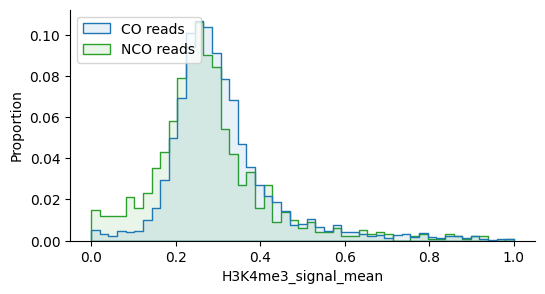

In [42]:
fig, ax = plt.subplots(figsize=(6, 3))

df = (dense_reads_with_detection_df
#    .filter(pl.col("sample_id") == sample_id)
    .filter(pl.col("high_quality_classification_in_detectable_class").is_not_null())
    .select(
        "H3K4me3_signal_mean",
        "high_quality_classification_in_detectable_class",
    )
)
CO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "CO")["H3K4me3_signal_mean"]
NCO_lens = df.filter(pl.col("high_quality_classification_in_detectable_class") == "NCO")["H3K4me3_signal_mean"]
all_lens = dense_reads_with_detection_df.sample(fraction=1e-4)["H3K4me3_signal_mean"]

sns.histplot(
    [
        pd.Series((CO_lens), name="CO"),
        pd.Series((NCO_lens), name="NCO"),
        #pd.Series((all_lens), name="All reads"),
    ], 
    #bins=np.linspace(-1, 0, 50),
    bins=np.linspace(0, 1, 50),
    #multiple="dodge",
    #shrink=0.8,
    stat="proportion",
    common_norm=False,
    element="step",
    #kde=True,
    palette=[CO_color, NCO_color, background_color],
    #fill=False,
    alpha=0.1,
    ax=ax,
)

ax.set_xlabel("H3K4me3_signal_mean");
# ax.set_xticks(
#     np.arange(-5, 1),
#     [f"$10^{{{x}}}$" for x in np.arange(-5, 1)],
# );
ax.legend(
    ax.get_legend().legend_handles, 
    ["CO reads", "NCO reads", "All reads"], 
    loc="upper left",
);

ax.spines[['right', 'top']].set_visible(False)

# Paper figure

KeyError: 'PD50508b'

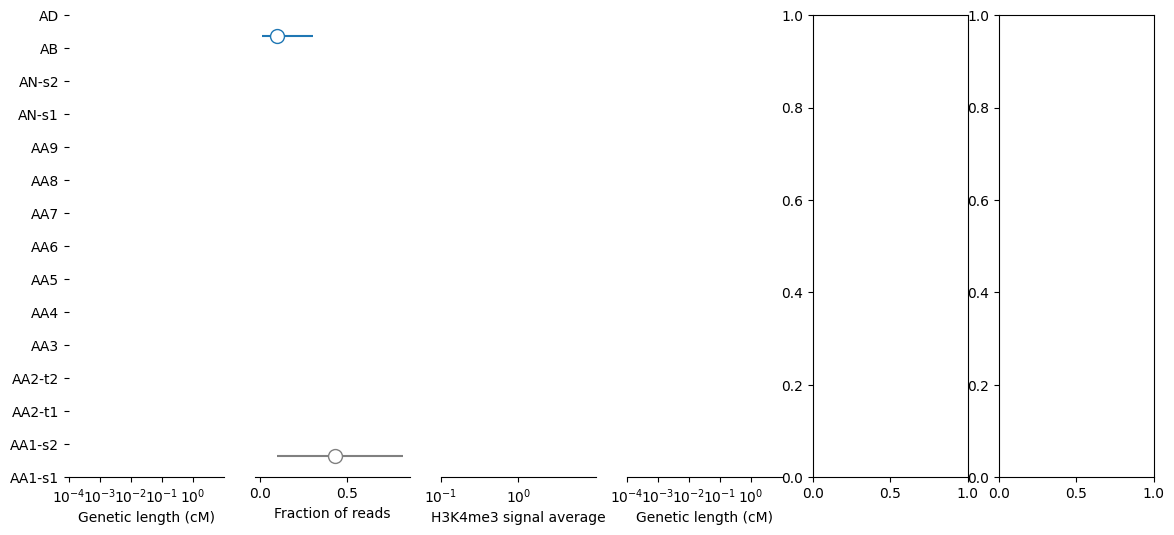

In [30]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=6,
    figsize=(14, 6),
    width_ratios=[25, 25, 25, 25, 25, 25],
)


inference.plot_boxplots_samples(
    test_df = (CO_NCO_df
        .filter(pl.col("high_quality_classification_class") == "CO")
        .with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2)
    ),
    test_column = "cM",
    xlabel = "Genetic length (cM)",
    take_log10=True,
    ticks = np.arange(-4, 1),
    label_to_color={
        "AN-s1": CO_color,
        "AN-s2": CO_color,
        "AB": CO_color,
        "AD": CO_color,
        "AA1-s1": CO_color,
        "AA1-s2": CO_color,
    },
    ax = axs[0],
);

ax = axs[1] 
for i in range(len(mns_co)):
    color = "grey"
    if sample_id_to_paper_label[sample_presentation_order[i]] in ["AD", "AA1-s1", "AA2-t1"]:
        color = CO_color
        
        
    ax.errorbar(
        y = i,
        x = mns_co[i],
        xerr = [[mns_co[i] - cis_co[i][0]], [cis_co[i][1] - mns_co[i]]],
        color=color,
        marker='o', 
        mfc='w',
        ms=10,
    )
ax.invert_yaxis()
ax.set_yticks([], [])
ax.set_xlabel("Fraction of reads");
ax.spines[['top', 'right', 'left']].set_visible(False)
    


inference.plot_boxplots_samples(
    test_df = (CO_NCO_df
        .filter(pl.col("high_quality_classification_class") == "CO")
    ),
    test_column = "H3K4me3_signal_mean",
    xlabel = "H3K4me3 signal average",
    take_log10 = True,
    ticks = np.arange(-1, 1),
    label_to_color={
        "AA2-t2": CO_color,
        "AA8": CO_color,
    },
    show_labels = False,
    ax = axs[2]
);




inference.plot_boxplots_samples(
    test_df = (CO_NCO_df
        .filter(pl.col("high_quality_classification_class") == "GC")
        .with_columns(cM=pl.col("CO_active_interval_crossover_prob")*1e2)
    ),
    test_column = "cM",
    xlabel = "Genetic length (cM)",
    take_log10 = True,
    ticks = np.arange(-4, 1),
    label_to_color={
        "AA5": NCO_color,
        "AA2-t2": NCO_color,
    },
    show_labels = False,
    ax = axs[3]
);




# NCOs
mns_nco = [(1 - Drows[s]["n_NCO_zeros"]/Drows[s]["n_NCO"]) \
       for s in sample_presentation_order[:-1]]
cis_nco = [statsmodels.stats.proportion.proportion_confint(
    Drows[s]["n_NCO"] - Drows[s]["n_NCO_zeros"],
    Drows[s]["n_NCO"],
    method="beta",
) for s in sample_presentation_order[:-1]]

ax = axs[4]
for i in range(len(mns_co)):
    color = "grey"
    if sample_id_to_paper_label[sample_presentation_order[i]] in ["AA5", "AN-s1", "AA1-s2", "AA2-t1", "AB"]:
        color = NCO_color
        
        
    ax.errorbar(
        y = i,
        x = mns_nco[i],
        xerr = [[mns_nco[i] - cis_nco[i][0]], [cis_nco[i][1] - mns_nco[i]]],
        color=color,
        marker='o', 
        mfc='w',
        ms=10,
    )
ax.invert_yaxis()
ax.set_yticks([], [])
ax.set_xlabel("Fraction of reads");
ax.spines[['top', 'right', 'left']].set_visible(False)



inference.plot_boxplots_samples(
    test_df = (CO_NCO_df
        .filter(pl.col("high_quality_classification_class") == "GC")
    ),
    test_column = "H3K4me3_signal_mean",
    xlabel = "H3K4me3 signal average",
    take_log10 = True,
    ticks = np.arange(-1, 1),
    label_to_color={
        "AA3": NCO_color,
        "AA4": NCO_color,
        "AA6": NCO_color,
        "AA2-t1": NCO_color,
    },
    show_labels = False,
    ax = axs[5]
);




fig.tight_layout();

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/ind_var.pdf")